In [1]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
import pandas as pd
import copy
import matplotlib.pyplot as plt
import time 

# K-Fold Cross Validation

In this notebook, you will practice using K-fold cross validation to compare two regression models:\
• Kernel Ridge Regression\
• Regression Decision Trees

## Note: 
You do not need to understand how these models work right now, you can simply use the provided fit_and_predict functions to get their predictions.

## Notebook Goals
The main goal is to practice and understand K-fold cross validation. The notebook is divided into 5 parts:
	1.	Create a function to split the data into k folds
	2.	Create a function to calculate the Root Mean Squared Error (RMSE) as the performance metric
	3.	Write a function to run cross validation using the k-folds
	4.	Run cross validation for values of k = {2, …, 100}, and measure the runtime for each
	5.	Answer the reflection questions in a markdown cell

## Important Note
Before submitting the notebook:
	• Restart the kernel
	• Re-run all cells
This ensures your results are fresh and consistent.

## Data Description
You will use a toy dataset from the scikit-learn library:
	• Inputs: ten baseline variables measured in diabetes patients
	• Output: a quantitative measure of disease progression one year later

## Data
We will use a sklearn toy dataset. The input values for this dataset are ten baseline variables measured in diabetes patients and the output is a quantitative measure of disease progression one year later. You can read more about the data [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

In [5]:
# Do not edit this cell 

X_, y_ = load_diabetes(return_X_y=True)

# standardise the data to help us fit the data (this will be covered later in the course)

scaler = preprocessing.StandardScaler().fit(X_)
X = scaler.transform(X_)[:300, :]

scaler_y = preprocessing.StandardScaler().fit(y_.reshape(-1, 1))
y = scaler_y.transform(y_.reshape(-1, 1))[:300, :]
print(y.shape)

# to ensure the data stays in the correct order, we will work with dataframes 

columns = [f'x_{i}' for i in range(X.shape[1])] + ['y']
x_columns = [f'x_{i}' for i in range(X.shape[1])]
data = pd.DataFrame(data= np.concatenate([X, y.reshape(-1, 1)], axis=1), columns=columns)
print(data.head())

(300, 1)
        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0  0.800500  1.065488  1.297088  0.459841 -0.929746 -0.732065 -0.912451   
1 -0.039567 -0.938537 -1.082180 -0.553505 -0.177624 -0.402886  1.564414   
2  1.793307  1.065488  0.934533 -0.119214 -0.958674 -0.718897 -0.680245   
3 -1.872441 -0.938537 -0.243771 -0.770650  0.256292  0.525397 -0.757647   
4  0.113172 -0.938537 -0.764944  0.459841  0.082726  0.327890  0.171178   

        x_7       x_8       x_9         y  
0 -0.054499  0.418531 -0.370989 -0.014719  
1 -0.830301 -1.436589 -1.938479 -1.001659  
2 -0.054499  0.060156 -0.545154 -0.144580  
3  0.721302  0.476983 -0.196823  0.699513  
4 -0.054499 -0.672502 -0.980568 -0.222496  


In [7]:
# Do not edit 

def fit_and_predict_KRR(train, validate):
    """fit a Kernel Ridge Regression Model on the training data and predict the y values of the validation X data.
    :param train: pandas dataframe containing the training data
    :param validate: pandas dataframe containing the validation data 
    :return: predictions at the validation X points Mx1 numpy array"""
    X_train = train[x_columns].to_numpy()
    y_train = train['y'].to_numpy()
    X_val = validate[x_columns].to_numpy()
        
    KRR = KernelRidge(alpha=0.1, kernel='rbf', gamma=0.2,  degree=100)
    KRR.fit(X_train, y_train)
    return KRR.predict(X_val)
    
    
def fit_and_predict_DT(train, validate):
    """fit a Regression Decision Tree on the training data and predict the y values of the validation X data.
    :param train: pandas dataframe containing the training data
    :param validate: pandas dataframe containing the validation data 
    :return: predictions at the validation X points Mx1 numpy array"""
    
    X_train = train[x_columns].to_numpy()
    y_train = train['y'].to_numpy()
    X_val = validate[x_columns].to_numpy()
        
    DTree = DecisionTreeRegressor(max_depth=6)
    DTree.fit(X_train, y_train)
    return DTree.predict(X_val)


##  Part 1: Creating the Folds
### Task:
code a function that splits the dataset into k folds for cross-validation.

In [8]:

def k_folds(data, k):
    """function that returns a list of k folds of the data"""
    
    ############################
    # Create list of how long each fold should be. The folds should be as even as possible in number, but some may
    # need to have an extra data point if the total number of data points isn't divisible by n
    len_folds = [int(sum(x)) for x in np.array_split(np.ones(len(data)), k)]
    ############################

    folds = []
    for i in range(k):
        data_ss = data.sample(n=len_folds[i], random_state=20)
        data = data.drop(data_ss.index)
        folds.append(data_ss)

    return folds 

## Part 2: Performance Metric

### TASK:
Write a function that calculates the Root Mean Squared Error (RMSE) between predicted values and the actual y values.
Both inputs should be NumPy arrays.
The function should return the RMSE as a float.


In [13]:
def rmse(prediction, true):
    return np.sqrt(np.mean(np.square(prediction-true)))

## Part 3: Cross Valiation

### TASK:
Create a function to run the cross validation on both the models by filling out the gaps in the function below. This function will return the average RMSE for each of the models. 

In [16]:
def cross_validation(folds):
    folds = copy.copy(folds) # this creates a new variable which is a copy of folds

    rmses_KRR = []  # list to collect the rmses for each fold for the Kernel Ridge Regression
    rmses_DT = []   # list to collect the rmses for each fold for the Decision Tree
    for i, fold in enumerate(folds):
        
        ############################
        # Write code to create the training and validation sets as DataFrames
        
        train = pd.concat(folds[:i]+folds[(i+1):])
#         train = pd.concat([folds.pop(i)])
        validate = fold
        
        ############################
        
        ############################
        # Use the fit_and_predict functions to create new columns in the validation set for the predictions 
        # for each model with headings ['KRR_predictions', 'DT_predictions'].
        
        validate['KRR_predictions'] = fit_and_predict_KRR(train, fold)
        validate['DT_predictions'] = fit_and_predict_DT(train, fold)
        
        ############################
        
        ############################
        # calculate the rmse for the two models and append to rmses_KRR and rmses_DT
        
        rmses_KRR.append(rmse(validate['KRR_predictions'].to_numpy(), validate['y'].to_numpy()))
        rmses_DT.append(rmse(validate['DT_predictions'].to_numpy(), validate['y'].to_numpy()))
        
        ############################

    RMSE_KRR = np.mean(rmses_KRR) # calculate the average RMSEs for kernel ridge regression
    RMSE_DT = np.mean(rmses_DT)# calculate the average RMSEs for the decision tree 
    return RMSE_KRR, RMSE_DT


### TASK: 
For k = 100 calculate the RMSE for each model and print the solutions 

In [19]:
folds =  k_folds(data, 100)
RMSE_KRR, RMSE_DT = cross_validation(copy.copy(folds))
print(RMSE_KRR, RMSE_DT)

0.795341390496453 0.7726041936357965


## Part 4: Cross Validation for Different Values of k
### TASK:
for k in {2, ..., 100} divide the data into k folds and then run cross validation. Save the results for each run in two lists (one for each model) and then plot a graph of k on the x-axis and RMSE on the y_axis. 
Use the time function (example in cell below) to time how long the cross validation takes for each value of k. Make a plot of the time against the value of k. 

In [22]:
# time function example

start = time.time()
print('hello')
end = time.time()
print(end - start)

hello
0.0001938343048095703


Text(0.5, 0, 'k')

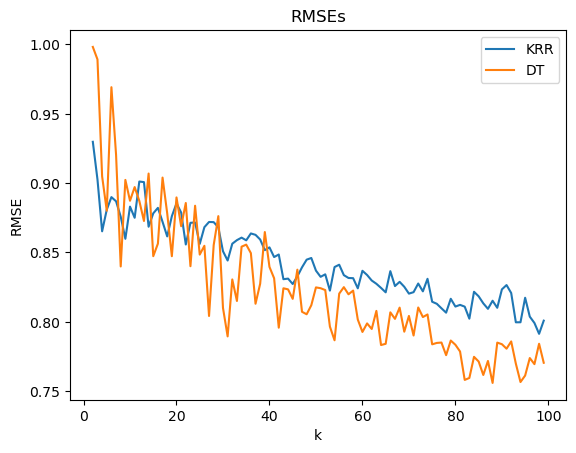

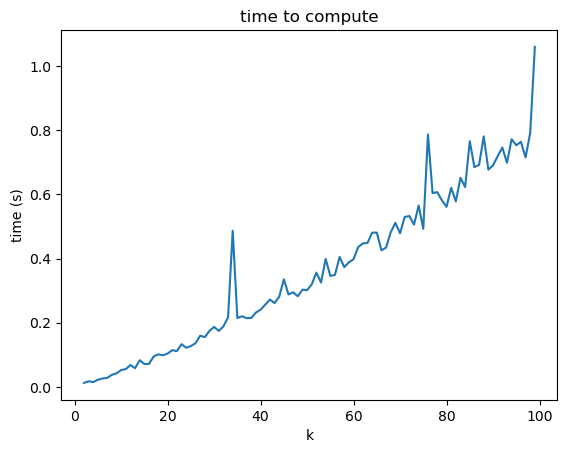

In [28]:
K=100
KRRs = []
DTs = []
times = []
for k in range(2, K):
    start = time.time()
    folds = k_folds(data, k)
    RMSE_KRR, RMSE_DT = cross_validation(folds)
    end = time.time()
    KRRs.append(RMSE_KRR)
    DTs.append(RMSE_DT)
    times.append(end - start)

    
plt.plot(list(range(2,K)), KRRs, label='KRR')
plt.plot(list(range(2,K)), DTs, label='DT')
plt.legend()
plt.title('RMSEs')
plt.ylabel('RMSE')
plt.xlabel('k')

fig = plt.figure()
plt.plot(list(range(2,K)), times)
plt.title('time to compute')
plt.ylabel('time (s)')
plt.xlabel('k')

## Part 5: Questions

### TO DO:

Answer the following questions in a markdown cell.
	1. Which model would you select based on your cross-validation results? Why?
	2. Looking at the two plots you made, what are the benefits and drawbacks of increasing k?

### ANSWER:
I would select the Decision Tree Regression model because it achieved the lowest RMSE (Root Mean Squared Error), indicating the best predictive performance.
As k increases, the results become more consistent and stable, which improves reproducibility. However, the downside is that computational time and resource usage increase, making the process slower and potentially more expensive.